# Pymaceuticals Inc. Analysis
---

- Module 5 Challenge: "You've just joined Pymaceuticals, Inc., a new pharmaceutical company that specializes in anti-cancer medications. Recently, it began screening for potential treatments for squamous cell carcinoma (SCC), a commonly occurring form of skin cancer. As a senior data analyst at the company, you've been given access to the complete data from their most recent animal study. In this study, 249 mice who were identified with SCC tumors received treatment with a range of drug regimens. Over the course of 45 days, tumor development was observed and measured. The purpose of this study was to compare the performance of Pymaceuticals’ drug of interest, Capomulin, against the other treatment regimens. The executive team has tasked you with generating all of the tables and figures needed for the technical report of the clinical study. They have also asked you for a top-level summary of the study results."
  
- The following notebook was developed from the provided starter code.
  
- Student name: Steph Abegg

- # Observations or inferences that can be made from the Analysis:
  
   (1) The bar chart of the number of datapoints (i.e. mice/timestamps) for each of the ten drug regimens in the study shows that there are between 150-230 unique datapoints for each drug regimens. Ideally there would be exactly the same unique datapoints for each drug regimen to directly compare the results, but at least there are a comparable number of datapoints for each drug regimen.
  
   (2) The pie chart of the number of male and female mice shows that, within error, there is an equal number of male (50.4%) and female (49.6%) mice in the study, so the study is not biased towards a gender of mouse.
  
   (3) The boxplot of final tumor volumes shows that, of the four most promising treatment regimens (Capomulin, Ramicane, Infubinol, and Ceftamin), the Capomulin and Ramicane have the lowest final tumor volumes.
  
   (4) The lineplot of tumor volume over time shows that the Capomulin results in a generally shrinking tumor over time for all but one mouse taking Capomulin. This indicates that Capomulin is indeed a reliable drug for shriking tumors, but that there may be the rare case where a mouse will not respond to the drug.
  
   (5) The tumor volume vs. mouse weight scatter plot shows that the higher mouse weight leads to larger tumor volumes, and that the correlation is quite strong (R=0.84). This makes sense, because the tumor weight will be part of the mouse's body weight, so a higher tumor weight correlates with a higher mouse body weight.
  
---
 

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st # for linear regression model
import numpy as np
import seaborn as sb # I used this for experimenting with another way to do boxplots, just for fun

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

# Combine the data into a single DataFrame, inner join to make sure we get the mice in the study
study_results_df = pd.merge(study_results, mouse_metadata, how = 'inner', on = "Mouse ID")

# Display the data table for preview
study_results_df.head()

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,b128,0,45.0,0,Capomulin,Female,9,22
1,f932,0,45.0,0,Ketapril,Male,15,29
2,g107,0,45.0,0,Ketapril,Female,2,29
3,a457,0,45.0,0,Ketapril,Female,11,30
4,c819,0,45.0,0,Ketapril,Male,21,25


In [2]:
# Checking the number of mice. Use the merged data to make sure this is the number of mice in the study.
mouse_count = study_results_df["Mouse ID"].nunique()
mouse_count

249

In [3]:
# Our data should be uniquely identified by Mouse ID and Timepoint
# Get the duplicate mice by ID number that shows up for Mouse ID and Timepoint.
duplicate_rows = study_results_df.duplicated(subset=["Mouse ID", "Timepoint"])
duplicate_mice = study_results_df[duplicate_rows]["Mouse ID"].unique()
print(duplicate_mice)

['g989']


In [4]:
# Optional: Get all the data for the duplicate mouse ID.
study_results_df[study_results_df["Mouse ID"] == duplicate_mice[0]]

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
107,g989,0,45.000000,0,Propriva,Female,21,26
137,g989,0,45.000000,0,Propriva,Female,21,26
329,g989,5,48.786801,0,Propriva,Female,21,26
360,g989,5,47.570392,0,Propriva,Female,21,26
620,g989,10,51.745156,0,Propriva,Female,21,26
681,g989,10,49.880528,0,Propriva,Female,21,26
815,g989,15,51.325852,1,Propriva,Female,21,26
869,g989,15,53.442020,0,Propriva,Female,21,26
950,g989,20,55.326122,1,Propriva,Female,21,26
1111,g989,20,54.657650,1,Propriva,Female,21,26


In [5]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.
# There is only one duplicate mouse, so it is easiest to just manually give its ID (which equals duplicate_mice[0])
# If there was more than one duplicate mouse, could loop through the duplicate_mice list
study_results_df.drop(study_results_df[study_results_df["Mouse ID"] == "g989"].index, inplace = True)
study_results_df.head()

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,b128,0,45.0,0,Capomulin,Female,9,22
1,f932,0,45.0,0,Ketapril,Male,15,29
2,g107,0,45.0,0,Ketapril,Female,2,29
3,a457,0,45.0,0,Ketapril,Female,11,30
4,c819,0,45.0,0,Ketapril,Male,21,25


In [6]:
# Checking the number of mice in the clean DataFrame.
# It is indeed one fewer mouse
mouse_count = study_results_df["Mouse ID"].nunique()
mouse_count

248

## Summary Statistics

In [7]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

# Use groupby and summary statistical methods to calculate the following properties of each drug regimen:
# mean, median, variance, standard deviation, and SEM of the tumor volume.
mean_tumor_volume = study_results_df.groupby("Drug Regimen")["Tumor Volume (mm3)"].mean()
median_tumor_volume = study_results_df.groupby("Drug Regimen")["Tumor Volume (mm3)"].median()
var_tumor_volume = study_results_df.groupby("Drug Regimen")["Tumor Volume (mm3)"].var()
std_tumor_volume = study_results_df.groupby("Drug Regimen")["Tumor Volume (mm3)"].std()
sem_tumor_volume = study_results_df.groupby("Drug Regimen")["Tumor Volume (mm3)"].sem()

# Assemble the resulting series into a single summary DataFrame.
per_drug_summary = {"Mean Tumor Volume": mean_tumor_volume, 
                    "Median Tumor Volume": median_tumor_volume, 
                    "Tumor Volume Variance": var_tumor_volume, 
                    "Tumor Volume Std. Dev.": std_tumor_volume, 
                    "Tumor Volume Std. Err.": sem_tumor_volume}
per_drug_summary = pd.DataFrame(data = per_drug_summary)
per_drug_summary.index.name = "Drug Regimen"

# Display the DataFrame
per_drug_summary

,Mean Tumor Volume,Median Tumor Volume,Tumor Volume Variance,Tumor Volume Std. Dev.,Tumor Volume Std. Err.
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


In [8]:
# A more advanced method to generate a summary statistics table of mean, median, variance, standard deviation,
# and SEM of the tumor volume for each regimen (only one method is required in the solution)

# Using the aggregation method, produce the same summary statistics in a single line
per_drug_summary_quicker = study_results_df.groupby("Drug Regimen").agg({"Tumor Volume (mm3)":['mean','median','var','std','sem']})
per_drug_summary_quicker

Tumor Volume (mm3)                                          
                           mean     median        var       std       sem
Drug Regimen                                                             
Capomulin             40.675741  41.557809  24.947764  4.994774  0.329346
Ceftamin              52.591172  51.776157  39.290177  6.268188  0.469821
Infubinol             52.884795  51.820584  43.128684  6.567243  0.492236
Ketapril              55.235638  53.698743  68.553577  8.279709  0.603860
Naftisol              54.331565  52.509285  66.173479  8.134708  0.596466
Placebo               54.033581  52.288934  61.168083  7.821003  0.581331
Propriva              52.320930  50.446266  43.852013  6.622085  0.544332
Ramicane              40.216745  40.673236  23.486704  4.846308  0.320955
Stelasyn              54.233149  52.431737  59.450562  7.710419  0.573111
Zoniferol             53.236507  51.818479  48.533355  6.966589  0.516398

## Bar and Pie Charts

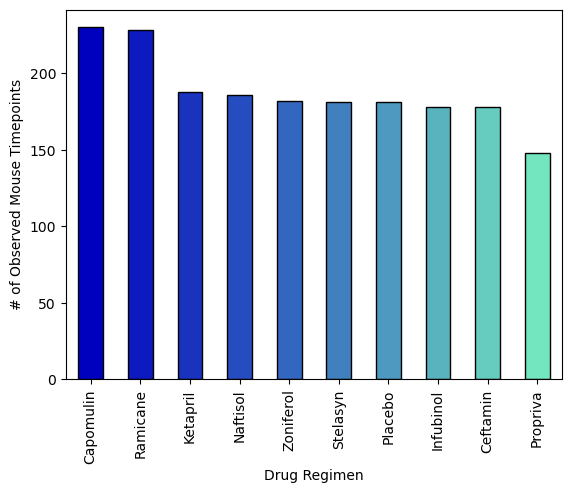

In [9]:
# Generate a bar plot showing the total number of rows (Mouse ID/Timepoints) for each drug regimen using Pandas.

# Gradient colors for fun
gradient_colors = [(x/20.0, x/10.0, 0.75) for x in range(len(per_drug_summary))] # len(per_drug_summary) = 10 drug regimens 

# Create bar plot
barplot = study_results_df["Drug Regimen"].value_counts().plot(kind = 'bar',
                                                                xlabel = "Drug Regimen",
                                                                ylabel = "# of Observed Mouse Timepoints",
                                                                color = gradient_colors,
                                                                edgecolor = "black")

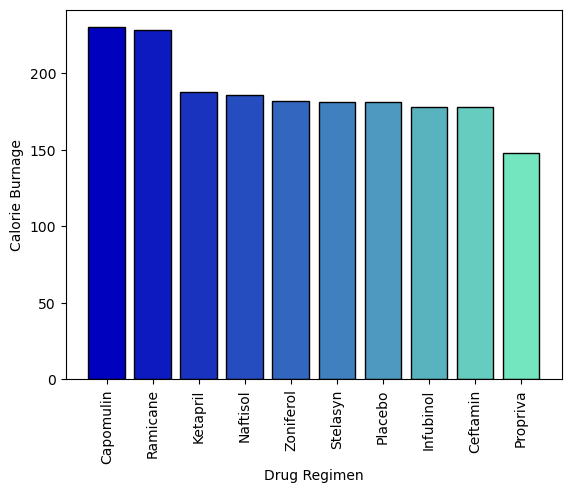

In [10]:
# Generate a bar plot showing the total number of rows (Mouse ID/Timepoints) for each drug regimen using pyplot.

# Gradient colors for fun
gradient_colors = [(x/20.0, x/10.0, 0.75) for x in range(len(per_drug_summary))] # len(per_drug_summary) = 10 drug regimens 

# Create bar plot
plt.bar(x = study_results_df["Drug Regimen"].value_counts().index, # orders bar labels correctly
       height = study_results_df["Drug Regimen"].value_counts(), 
       color = gradient_colors, 
       edgecolor = "black")
plt.xticks(rotation = "vertical")  # plt.tick_params(axis='x', labelrotation=90) works too
plt.xlabel("Drug Regimen")
plt.ylabel("Calorie Burnage")
plt.show()

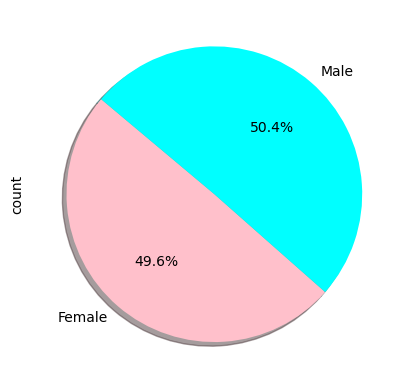

In [11]:
# Generate a pie chart, using Pandas, showing the distribution of unique female versus male mice used in the study

# Get the number of unique mice with their gender
#mouse_count_female = study_results_df[study_results_df["Sex"] == "Female"]["Mouse ID"].nunique()
#mouse_count_male = study_results_df[study_results_df["Sex"] == "Male"]["Mouse ID"].nunique()
mouse_count_gender = study_results_df.groupby("Sex")["Mouse ID"].nunique()

# Make the pie chart
piechart = mouse_count_gender.plot(kind = 'pie',
                                   autopct = '%1.1f%%',
                                   ylabel = "count",
                                   colors = ['pink', 'cyan'],
                                   shadow = True,
                                   startangle = 140)

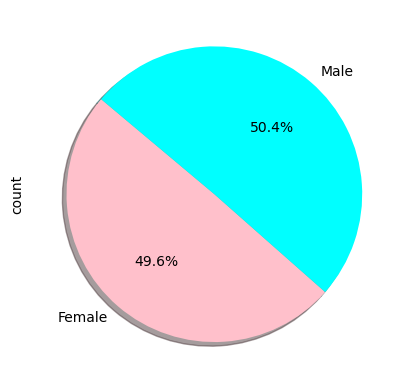

In [12]:
# Generate a pie chart, using pyplot, showing the distribution of unique female versus male mice used in the study

# Get the unique mice with their gender
mouse_count_gender = study_results_df.groupby("Sex")["Mouse ID"].nunique()

# Make the pie chart
plt.pie(mouse_count_gender, 
       labels = mouse_count_gender.index, # "Female, Male
       autopct = '%1.1f%%', 
       colors = ['pink', 'cyan'],
       shadow = True, 
       startangle = 140)
plt.ylabel("count")
plt.show()

## Quartiles, Outliers and Boxplots

In [13]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:
# Capomulin, Ramicane, Infubinol, and Ceftamin

# Start by getting the last (greatest) timepoint for each mouse
last_timepoint_by_mouse = study_results_df.groupby("Mouse ID")["Timepoint"].max()
last_timepoint_by_mouse_df = pd.DataFrame(data = last_timepoint_by_mouse)

# Merge this group df with the original DataFrame to get the tumor volume at the last timepoint
final_tumor_volume_by_mouse_df = pd.merge(last_timepoint_by_mouse_df, study_results_df, how = 'inner', 
                                            left_on = ["Mouse ID", "Timepoint"], right_on = ["Mouse ID", "Timepoint"])
final_tumor_volume_by_mouse_df.head()

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,a203,45,67.973419,2,Infubinol,Female,20,23
1,a251,45,65.525743,1,Infubinol,Female,21,25
2,a262,45,70.717621,4,Placebo,Female,17,29
3,a275,45,62.999356,3,Ceftamin,Female,20,28
4,a366,30,63.440686,1,Stelasyn,Female,16,29


In [14]:
# Put treatments into a list for for loop (and later for plot labels)
# drug_treatments = list(final_tumor_volume_by_mouse_df["Drug Regimen"].unique()) # all treatments
drug_treatments = "Capomulin", "Ramicane", "Infubinol", "Ceftamin" # the four treatments we were told to investigate

# Create empty list to fill with tumor vol data (for plotting)
final_tumor_volume_by_drug_all = []
outliers_all = []

# Calculate the IQR and quantitatively determine if there are any potential outliers.
for drug in drug_treatments:

    # Initialize lists
    final_tumor_volume_by_drug = []
    outliers = []
    
    # Locate the rows which contain mice on drug and get the final tumor volumes
    for index, row in final_tumor_volume_by_mouse_df.iterrows():
        if row["Drug Regimen"] == drug:
            final_tumor_volume_by_drug.append(row["Tumor Volume (mm3)"])
    # add to master list
    final_tumor_volume_by_drug_all.append(final_tumor_volume_by_drug)

    # Determine outliers using upper and lower bounds
    quartiles = pd.DataFrame(final_tumor_volume_by_drug).quantile([0.25,0.5,0.75]) # one way to get quartiles
    q1_value = quartiles.loc[0.25][0]
    q3_value = quartiles.loc[0.75][0]
    #q1_value = np.percentile(final_tumor_volume_by_drug, 25) # another way to get quartiles
    #q3_value = np.percentile(final_tumor_volume_by_drug, 75)
    iqr_value = q3_value - q1_value    
    for volume in final_tumor_volume_by_drug:
        if (volume < q1_value - 1.5*iqr_value) or (volume > q3_value + 1.5*iqr_value):
            outliers.append(volume)
    # add to master list
    outliers_all.append(outliers)
    # print outliers for drug
    print(f"{drug}'s potential outliers (final tumor volume in mm^3): {outliers}; \
    (Q1: {q1_value:.2f}, Q3: {q3_value:.2f}, IQR: {iqr_value:.2f})")

final_tumor_volume_by_drug_all = pd.DataFrame(data = final_tumor_volume_by_drug_all)
final_tumor_volume_by_drug_all = final_tumor_volume_by_drug_all.transpose()
final_tumor_volume_by_drug_all.columns = drug_treatments
#final_tumor_volume_by_drug_all

Capomulin's potential outliers (final tumor volume in mm^3): [];     (Q1: 32.38, Q3: 40.16, IQR: 7.78)
Ramicane's potential outliers (final tumor volume in mm^3): [];     (Q1: 31.56, Q3: 40.66, IQR: 9.10)
Infubinol's potential outliers (final tumor volume in mm^3): [36.3213458];     (Q1: 54.05, Q3: 65.53, IQR: 11.48)
Ceftamin's potential outliers (final tumor volume in mm^3): [];     (Q1: 48.72, Q3: 64.30, IQR: 15.58)


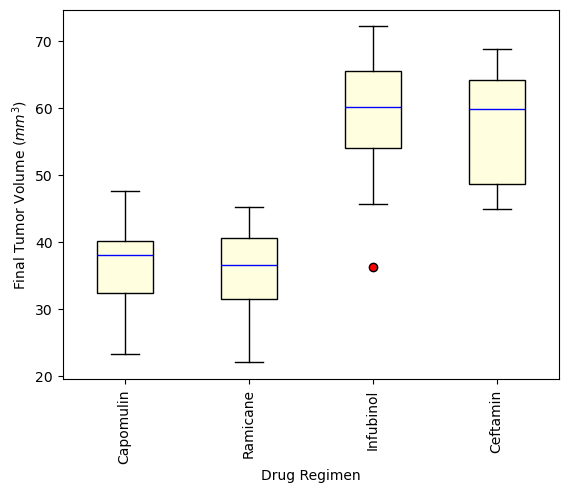

In [15]:
# Generate a box plot that shows the distribution of the tumor volume for each treatment group.

# Sort by highest to lowest median - this wasn't required but I played around with it for fun
#medians = final_tumor_volume_by_drug_all.median()
#medians.sort_values(ascending = False, inplace = True)
#final_tumor_volume_by_drug_all = final_tumor_volume_by_drug_all[medians.index]
#drug_treatments = medians.index

# Generate box plot with Seaborn (ignores NaN correctly)
#bplot = sb.boxplot(final_tumor_volume_by_drug_all, 
#                   color = 'lightyellow', # fill with light yellow
#                   flierprops = dict(marker = 'o', markerfacecolor = 'red'), # color any outliers red
#                   medianprops = dict(color = 'blue')) # color median line blue
#bplot.set_xlabel("Drug Regimen")
#bplot.set_ylabel("Final Tumor Volume ($mm^3$)")
#bplot.tick_params(axis = 'x', labelrotation=90)

# Generate box plot with Pandas (handles NaN correctly)
#bplot = final_tumor_volume_by_drug_all.plot(kind = 'box', 
#                                            rot = 90, 
#                                            showfliers = True, flierprops = dict(markerfacecolor = 'red'),
#                                            boxprops = dict(linestyle='-', facecolor = 'lightyellow'),
#                                            patch_artist = True,
#                                            color = dict(boxes='lightyellow', whiskers='black', medians='blue', caps='black'))
#bplot.set_xlabel("Drug Regimen")
#bplot.set_ylabel("Final Tumor Volume ($mm^3$)")
#plt.show()

# Generate box plot with Matplotlib PyPlot 
# (does not handle NaN correctly, dropna() will remove entire row; but the chosen drug treatments do not have NaN)
plt.boxplot(final_tumor_volume_by_drug_all,
            flierprops = dict(marker = 'o', markerfacecolor = 'red'), # color any outliers red
            patch_artist = True, boxprops = dict(facecolor = 'lightyellow'),  # fill with light yellow
            medianprops = dict(color = 'blue'), # color median line blue
            labels = drug_treatments) # label x axis
plt.xlabel("Drug Regimen")
plt.ylabel("Final Tumor Volume ($mm^3$)")
plt.tick_params(axis = 'x', labelrotation = 90)
plt.show()

## Line and Scatter Plots

Mice treated with Capomulin: ['b128' 'j246' 'r554' 's185' 'b742' 'x401' 'l509' 's710' 'r157' 'u364'
 'j119' 'v923' 'w914' 'i738' 'r944' 'y793' 'g316' 'g288' 'l897' 'w150'
 't565' 'i557' 'm957' 'f966' 'm601']


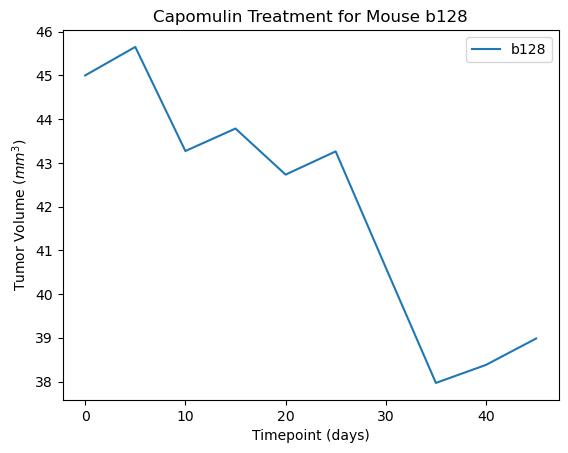

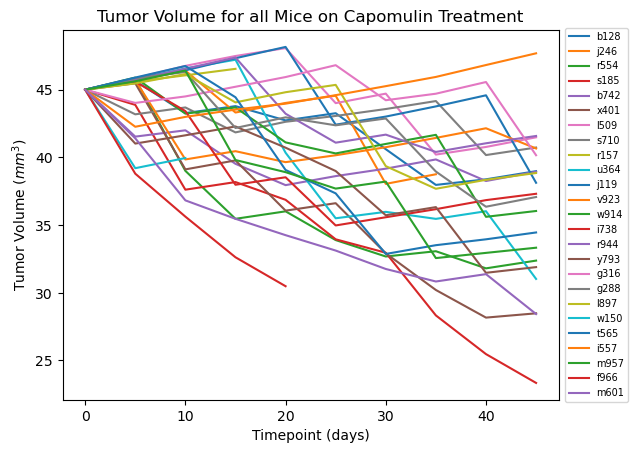

In [16]:
# Generate a line plot of tumor volume vs. time point for a single mouse treated with Capomulin

# Get list of all mice treated with Capomulin
mice_treated_with_Capomulin = study_results_df[study_results_df["Drug Regimen"] == "Capomulin"]["Mouse ID"].unique()
print(f"Mice treated with Capomulin: {mice_treated_with_Capomulin}")

# Plot line plot for a single mouse treated with Capomulin
ax = study_results_df[study_results_df["Mouse ID"] == mice_treated_with_Capomulin[0]].plot(
                                          kind = 'line',
                                          y = "Tumor Volume (mm3)",
                                          x = "Timepoint",
                                          xlabel = "Timepoint (days)",
                                          ylabel = "Tumor Volume ($mm^3$)",
                                          label = mice_treated_with_Capomulin[0],
                                          title = f"Capomulin Treatment for Mouse {mice_treated_with_Capomulin[0]}",
                                          legend = True
                                          )


# Plot line plot for all mice treated with Capomulin (this wasn't required)
for mouse in mice_treated_with_Capomulin:
    if mouse == mice_treated_with_Capomulin[0]:
        ax2 = study_results_df[study_results_df["Mouse ID"] == mouse].plot(
                                          kind = 'line',
                                          y = "Tumor Volume (mm3)",
                                          x = "Timepoint",
                                          xlabel = "Timepoint (days)",
                                          ylabel = "Tumor Volume ($mm^3$)",
                                          label = mouse,
                                          title = "Tumor Volume for all Mice on Capomulin Treatment",
                                          legend = True
                                          )
    else:
        ax2 = study_results_df[study_results_df["Mouse ID"] == mouse].plot(
                                          ax = ax2, 
                                          kind = 'line',
                                          y = "Tumor Volume (mm3)",
                                          x = "Timepoint",
                                          xlabel = "Timepoint (days)",
                                          label = mouse
                                          )
plt.legend(fontsize = 7, bbox_to_anchor = (1.15, 1.02))
plt.show()

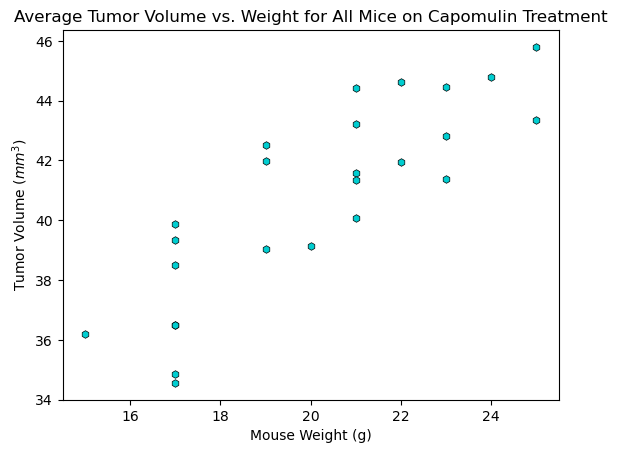

In [17]:
# Generate a scatter plot of mouse weight vs. the average observed tumor volume for the entire Capomulin regimen

# Create data frame with mouse weight and average tumor volume
weight_and_mean_tumor_vol = study_results_df[study_results_df["Drug Regimen"] == "Capomulin"].groupby(["Mouse ID"])[["Weight (g)","Tumor Volume (mm3)"]].mean()

# Create scatter plot
scatterplot = weight_and_mean_tumor_vol.plot(kind = 'scatter',
                                             x = "Weight (g)",
                                             y = "Tumor Volume (mm3)", 
                                             xlabel = "Mouse Weight (g)",
                                             ylabel = "Tumor Volume ($mm^3$)",
                                             title = "Average Tumor Volume vs. Weight for All Mice on Capomulin Treatment",
                                             c = "darkturquoise",
                                             edgecolors = "black",
                                             linewidths = 0.5,
                                             marker = "h",
                                             s = 30
                                             )

## Correlation and Regression

The correlation between mouse weight and the average tumor volume is R=0.84.


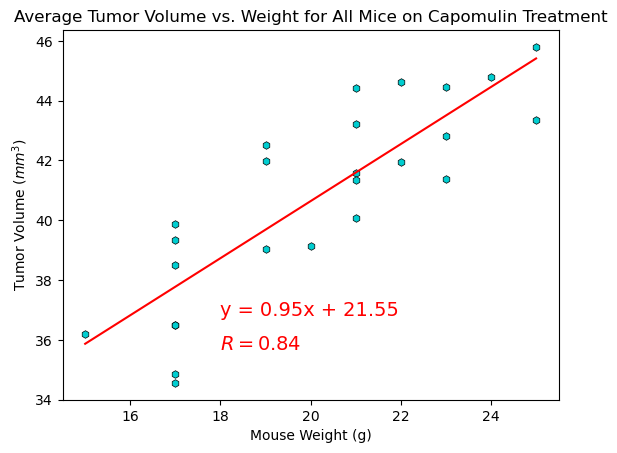

In [18]:
# Calculate the correlation coefficient and a linear regression model
# for mouse weight and average observed tumor volume for the entire Capomulin regimen

# Create scatter plot
scatterplot = weight_and_mean_tumor_vol.plot(kind = 'scatter',
                                             x = "Weight (g)",
                                             y = "Tumor Volume (mm3)", 
                                             xlabel = "Mouse Weight (g)",
                                             ylabel = "Tumor Volume ($mm^3$)",
                                             title = "Average Tumor Volume vs. Weight for All Mice on Capomulin Treatment",
                                             c = "darkturquoise",
                                             edgecolors = "black",
                                             linewidths = 0.5,
                                             marker = "h",
                                             s = 30
                                             )

# Find regression model using linregress in scripy.stats
xdata = weight_and_mean_tumor_vol["Weight (g)"]
ydata = weight_and_mean_tumor_vol["Tumor Volume (mm3)"]
slope, intercept, rvalue, pvalue, stderr = st.linregress(xdata, ydata)  # rvalue is the correlation coefficient, rvalue^2 is coefficeint of determination
ylinreg = slope*xdata + intercept # regression values

# plot regression model and correlation coefficient on scatterplot
scatterplot.plot(xlinreg, ylinreg, '-r')
scatterplot.text(.3*max(xdata)+.7*min(xdata),.1*max(ydata)+.9*min(ydata),'$R = %0.2f$'% rvalue, fontsize = 14, color='red')
scatterplot.text(.3*max(xdata)+.7*min(xdata),.2*max(ydata)+.8*min(ydata),f'y = {slope:0.2f}x + {intercept:0.2f}', fontsize = 14, color='red')
print(f"The correlation between mouse weight and the average tumor volume is R={rvalue:0.2f}.")